In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import getdist
import random
import emcee as mc
from getdist import plots, MCSamples
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
from chainconsumer import ChainConsumer
import scipy.interpolate as interpolate
import time
from scipy.interpolate import UnivariateSpline
import tensorflow as tf
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
from scipy.integrate import simps

In [2]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

Using TensorFlow backend.


# Load data

In [3]:
# Actual data
des_data_power = np.load('./data/DES_shear_power_binned.npy')
des_data_peaks = np.load('./data/DES_peaks.npy')

In [8]:
sim_param_repeated = np.loadtxt('../simulations/simulated_sv_maps/parameter_values_repeated.txt',
                               delimiter=',').T
param_points = np.loadtxt('../simulations/original_lensing_maps/parameter_values.txt',
                               delimiter=',').T

sim_params = np.vstack([sim_param_repeated[0], sim_param_repeated[2]]).T
sim_params_rescaled = np.vstack([sim_param_repeated[0], sim_param_repeated[2]]).T

sim_params_rescaled[:,0] = sim_params_rescaled[:,0] - 0.37
print(np.mean(sim_params_rescaled[:,0]), np.std(sim_params_rescaled[:,0]))
sim_params_rescaled[:,1] = sim_params_rescaled[:,1] - 0.77
print(np.mean(sim_params_rescaled[:,1]), np.std(sim_params_rescaled[:,1]))

0.0015562519589686788 0.18251257468965526
-0.0013513513513513239 0.1471267737903706


In [11]:
power_array = np.load('./simulated_summaries/simulated_power.npy')

fiducial_power_loc = [0.020003179578825796,0.00542567084605187,0.0026387078334836884,0.0020008674708306383,0.0014016950905390252,0.0009862673930773642,0.0007995315677352898,0.0005655933384722268,0.0003993450163250275,0.00028762368651779284,0.00019897668990853578,0.0001468498660456414,0.00010530480180279284,7.589862924614796e-05,5.222219492371919e-05,3.907954329722532e-05,3.2077274266851944e-05,2.563770347891647e-05]
fiducial_power_scale = [0.01732232314079786,0.004489364609700439,0.0021550178627635403,0.0015146318066180588,0.0009551675019049409,0.0008986407843371424,0.0006097077754401471,0.0004411125284513762,0.00031533892270972126,0.00023618089715103763,0.00018599258320050149,0.00013864647839347452,0.00010294966158315667,8.021368010672145e-05,6.516533094137465e-05,5.2776115476984885e-05,4.468822124854667e-05,8.04198768416175e-05]

power_array_rescaled = 0.5*(power_array - fiducial_power_loc)/fiducial_power_scale


In [13]:
peaks_array = np.load('./simulated_summaries/simulated_peaks.npy')

fiducial_peak_loc = [31.48198198198198,38.59534534534534,42.54354354354354,42.926426426426424,37.4481981981982,29.59984984984985,20.39864864864865,13.102852852852854,7.7807807807807805,4.247747747747748,2.198948948948949]
fiducial_peak_scale = [6.015905317777876,6.999940537131674,7.5500569014459,7.171263442497717,6.435253043858894,5.447381383877835,4.669828205742346,4.010020215846903,3.1736513756310716,2.4574827881567254,1.7155617297097812]

peaks_array_rescaled = 0.5*(peaks_array - fiducial_peak_loc)/fiducial_peak_scale

In [14]:
joint_noisy_sim = np.hstack([peaks_array, power_array])
joint_noisy_sim_rescaled = np.hstack([peaks_array_rescaled,power_array_rescaled])

des_data_power_rescaled = 0.5*(des_data_power - fiducial_power_loc)/fiducial_power_scale
des_data_peaks_rescaled = 0.5*(des_data_peaks - fiducial_peak_loc)/fiducial_peak_scale
joint_des_rescaled = np.atleast_2d(np.hstack([des_data_peaks_rescaled,des_data_power_rescaled]))

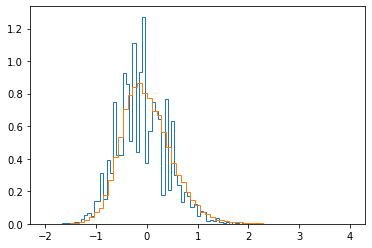

In [15]:
_  = plt.hist(peaks_array_rescaled.flatten(), bins = np.linspace(-2,2,64), density=True, histtype='step')
_  = plt.hist(power_array_rescaled.flatten(), bins = np.linspace(-2,4,64), density=True, histtype='step')

# Do compression

In [16]:
regression_joint = load_model('./joint_augmented_regressor_190620.h5')

In [17]:
sim_compressed_data = regression_joint.predict(joint_noisy_sim_rescaled)

In [18]:
compressed_des_data1 = regression_joint.predict(joint_des_rescaled)

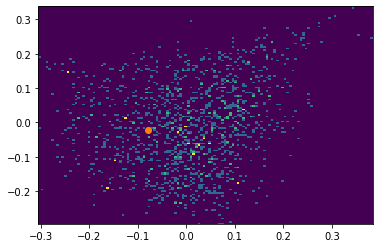

In [19]:
_ = plt.hist2d(sim_compressed_data.T[0], sim_compressed_data.T[1], bins = 128)
_ = plt.scatter(compressed_des_data1.T[0], compressed_des_data1.T[1], c='C1')

# DELFI

In [62]:
# Set priors
lower = np.array([0.1, 0.45])
upper = np.array([0.8, 1.05])
prior = priors.Uniform(lower, upper)

In [63]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=2, n_hiddens=[50,50], n_mades=4, act_fun=tf.tanh, index=0),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=2, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=1),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3)]


In [64]:
DelfiEnsemble = delfi.Delfi(np.array(compressed_des_data1[0,:], dtype = 'float'), prior, NDEs,
                            param_limits = [lower, upper],
                            param_names = ['\Omega_m', 'S_8'], 
                            results_dir = 'temp_joint2/')

DelfiEnsemble.load_simulations(np.array(sim_compressed_data, dtype = 'float'), sim_params)

DelfiEnsemble.train_ndes()

# Plot the learned distributions

In [65]:
om_grid, s8_grid = np.mgrid[lower[0]:upper[0]:96*1j,lower[1]:upper[1]:96*1j]
om_grid = om_grid.flatten()
s8_grid = s8_grid.flatten()

In [66]:
grid_likelihoods = np.empty((5,len(om_grid)))

for i in range(len(om_grid)):
    
    if i%1024==0:
        print(i)
        
    theta_temp = np.array([om_grid[i],s8_grid[i]]).T
    grid_likelihoods[0,i] = DelfiEnsemble.log_posterior_stacked(theta_temp,
                                                              data=compressed_des_data1)[0][0]
    grid_likelihoods[1,i] = DelfiEnsemble.log_posterior_individual(0,theta_temp,
                                                                 data=compressed_des_data1)[0][0]
    grid_likelihoods[2,i] = DelfiEnsemble.log_posterior_individual(1,theta_temp,
                                                                 data=compressed_des_data1)[0][0]
    grid_likelihoods[3,i] = DelfiEnsemble.log_posterior_individual(2,theta_temp,
                                                                 data=compressed_des_data1)[0][0]
    grid_likelihoods[4,i] = DelfiEnsemble.log_posterior_individual(3,theta_temp,
                                                                 data=compressed_des_data1)[0][0]

0
1024
2048
3072
4096
5120
6144
7168
8192


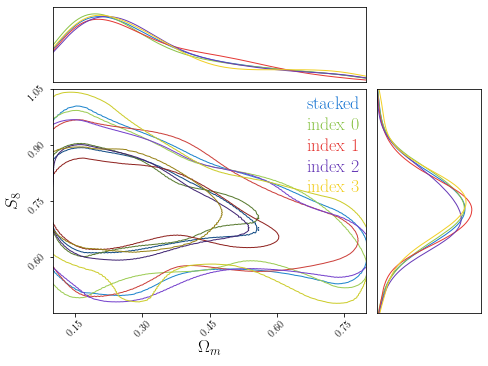

In [71]:
c = ChainConsumer()

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[0])/np.sqrt(om_grid/0.3), name='stacked')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[1])/np.sqrt(om_grid/0.3), name='index 0')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[2])/np.sqrt(om_grid/0.3), name='index 1')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[3])/np.sqrt(om_grid/0.3), name='index 2')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[4])/np.sqrt(om_grid/0.3), name='index 3')


c.configure(kde= [1.0,1.0,1.0,1.0,1.0,],sigmas = [1,2], label_font_size=18,
            shade = [False,False,False,False,False]) 

fig = c.plotter.plot(figsize = (7,5))

(['$\\Omega_m$', '$\\sigma_8$'], array([[ 0.02703402, -0.03484135],
       [-0.03484135,  0.06217754]]))


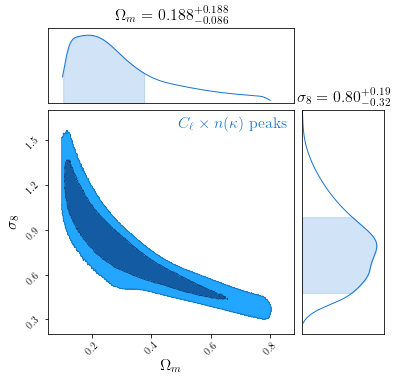

In [92]:
c = ChainConsumer()

c.add_chain([om_grid,s8_grid/np.sqrt(om_grid/0.3)],
            parameters=[r'$\Omega_m$', r'$\sigma_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[0])/np.sqrt(om_grid/0.3), name=r'$C_\ell \times n(\kappa)$ peaks')

c.configure(kde= [0.3],sigmas = [1,2], label_font_size=16,
            shade = [True]) 

fig = c.plotter.plot(figsize = (5.5,5), legend=True, extents=[[0.05,0.88],[0.2,1.7]], filename='augmented_joint_sigma8.pdf')


latex_table = c.analysis.get_covariance()
print(latex_table)

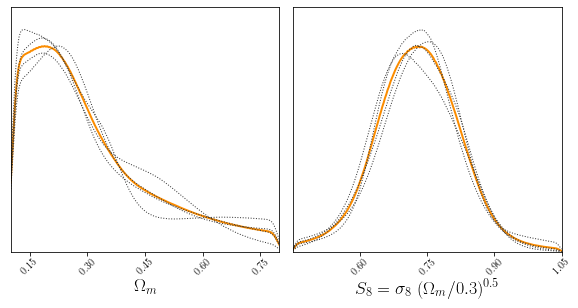

In [94]:
c = ChainConsumer()

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8 = \sigma_8 \ (\Omega_m / 0.3)^{0.5}$'], color='orange', linewidth=2.,
            grid=True, weights=np.exp(grid_likelihoods[0])/np.sqrt(om_grid/0.3), name='stacked')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8 = \sigma_8 \ (\Omega_m / 0.3)^{0.5}$'],
            linestyle = ':', color='black',
            grid=True, weights=np.exp(grid_likelihoods[1])/np.sqrt(om_grid/0.3), name='index 0')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8 = \sigma_8 \ (\Omega_m / 0.3)^{0.5}$'],
            linestyle = ':', color='black',
            grid=True, weights=np.exp(grid_likelihoods[2])/np.sqrt(om_grid/0.3), name='index 1')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8 = \sigma_8 \ (\Omega_m / 0.3)^{0.5}$'],
            linestyle = ':', color='black',
            grid=True, weights=np.exp(grid_likelihoods[3])/np.sqrt(om_grid/0.3), name='index 2')

c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8 = \sigma_8 \ (\Omega_m / 0.3)^{0.5}$'],
            linestyle = ':',color='black',
            grid=True, weights=np.exp(grid_likelihoods[4])/np.sqrt(om_grid/0.3), name='index 3')


c.configure(kde= [.2,.2,.2,.2,.2],label_font_size=18) 

fig = c.plotter.plot_distributions(figsize = (9,4.), extents=[[0.1,0.8],[0.45,1.05]], filename='marginals.pdf')

# Sampling the learned distribution
## Currently prior is flat over $S_8$ not $\sigma_8$

In [42]:
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/array of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [189]:
n_dim2d=2
n_burn2d=500
n_steps2d = 2000
n_walkers2d = 2 * n_dim2d

In [190]:
theta2d_expected_mean = [0.3, 0.75]

theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.1)) for i in range(n_walkers2d)])

In [194]:
def prior_term(theta2d):
    om, _ = theta2d.T
    result = np.where(om>0.05,-0.5*np.log(np.array(om)),-np.inf)
    return result

def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble.log_posterior_stacked(theta2d,data=data) + prior_term(theta2d)


sampler2d = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,
                             args=(compressed_des_data1,))

In [196]:
p = sampler2d.run_mcmc(theta0_2d, n_burn2d)

/Users/ucapnje/Documents/peaks/pydelfi/pydelfi_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/ucapnje/Documents/peaks/pydelfi/pydelfi_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


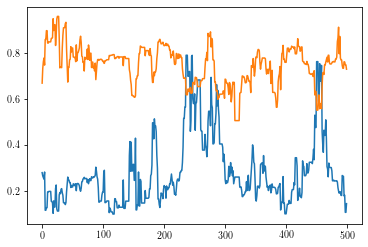

In [197]:
_ = sampler2d.run_mcmc(theta0_2d, n_burn2d)

plt.plot(sampler2d.chain[0,:n_burn2d,0])
plt.plot(sampler2d.chain[0,:n_burn2d,1])

In [198]:
t = time.time()
_ = sampler2d.run_mcmc(sampler2d.chain[:,-1,:], n_steps2d) #start from where we left off previously 

print(time.time() - t)
samples2d = sampler2d.get_chain(flat=True)

/Users/ucapnje/Documents/peaks/pydelfi/pydelfi_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


33.71585988998413


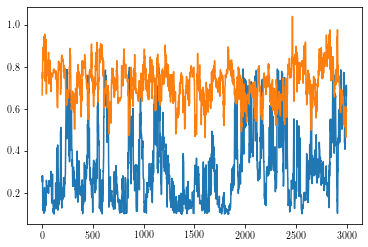

In [199]:
plt.plot(sampler2d.chain[0,:,0])
plt.plot(sampler2d.chain[0,:,1])

Prior here is flat in sigma_8


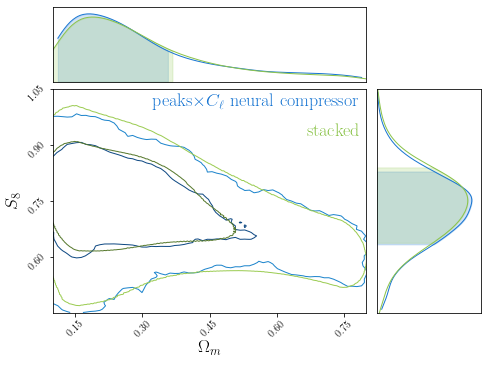

In [208]:
c = ChainConsumer()
print('Prior here is flat in sigma_8')

c.add_chain([samples2d.T[0],samples2d.T[1]],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            name = r'peaks$\times C_\ell$ neural compressor')


c.add_chain([om_grid,s8_grid],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[0])/np.sqrt(om_grid), name='stacked')


c.configure(kde= [0.8,0.8],sigmas = [1,2], label_font_size=18, shade = [False,False]) 



fig = c.plotter.plot(figsize = (7,5), filename='joint_neural.png')

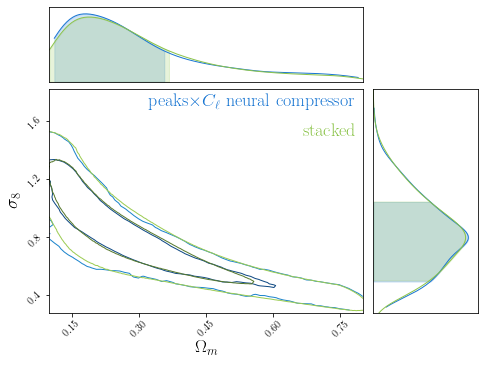

In [205]:
c = ChainConsumer()

c.add_chain([samples2d.T[0],samples2d.T[1]/np.sqrt(samples2d.T[0]/0.3)],
            parameters=[r'$\Omega_m$', r'$\sigma_8$'],linestyle = '-',
            name = r'peaks$\times C_\ell$ neural compressor')


c.add_chain([om_grid,s8_grid/np.sqrt(om_grid/0.3)],
            parameters=[r'$\Omega_m$', r'$\sigma_8$'],linestyle = '-',
            grid=True, weights=np.exp(grid_likelihoods[0])/np.sqrt(om_grid/0.3), name='stacked')


c.configure(kde= [0.8,0.8],sigmas = [1,2], label_font_size=18, shade = [False,False]) 



fig = c.plotter.plot(figsize = (7,5), filename='joint_neural.png')